# mini Bert 학습하기

In [1]:
!pip install sentencepiece

## 필요한 라이브러리 임포트

In [2]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 토크나이저 학습

In [7]:
# 파일 경로 지정
input_file = "/content/drive/MyDrive/Colab Notebooks/data/kowiki.txt"
model_prefix = "kowiki_spm"
vocab_size = 8000

# 모델 학습
spm.SentencePieceTrainer.train(
    input=input_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size + 7,
    model_type="bpe",
    max_sentence_length=999999,
    pad_id=0,
    pad_piece="[PAD]",
    unk_id=1,
    unk_piece="[UNK]",
    bos_id=2,
    bos_piece="[BOS]",
    eos_id=3,
    eos_piece="[EOS]",
    user_defined_symbols="[SEP],[CLS],[MASK]"
)

In [8]:
# 현재 디렉토리에 저장된 모델 불러오기
vocab = spm.SentencePieceProcessor()
vocab.load("kowiki_spm.model")  # .model 파일 직접 지정

# 예시
text = "한국어 문장을 토크나이즈합니다."
print("Tokens:", vocab.encode(text, out_type=str))
print("IDs:", vocab.encode(text, out_type=int))

Tokens: ['▁한국', '어', '▁문', '장을', '▁토', '크', '나이', '즈', '합', '니다', '.']
IDs: [318, 3633, 117, 480, 363, 3753, 1967, 3885, 3814, 1202, 3599]


In [9]:
# 특수 token 7개를 제외한 나머지 token들을 출력해봅시다.
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        token = vocab.id_to_piece(id)  # ID를 토큰으로 변환
        vocab_list.append(token)

print(vocab_list)

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '00', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지', '▁무', '▁남', '▁통', '▁현', '▁교', '▁같', '에게', '▁내', '학교', '▁문', '▁출', '▁거', '▁포', '▁결', '된다', '▁《', '적인', '이라', '▁6', '▁우', '적으로', '▁불', '▁원', '▁최', '▁진', '▁생', '▁작', '▁어', '▁당', '국의', '▁노', '▁강', '▁알', '▁반', '▁7', '▁8', '▁계', '▁따', '▁파', '▁분', '▁없', '▁받', '▁말', '면서', '들이', 'or', '되었', '▁사용', "▁'", '▁두', '▁실', '에서는', '▁10', '▁리', '들은', '▁명', '▁함', '▁단', '▁이후', '하기', '▁예', '년에', '),',

In [12]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


## 마스크 생성 함수

In [10]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    masked_num = 0
    original_num = 0
    random_num = 0
    # 띄어쓰기 단위로 mask하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # masking
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
                masked_num += 1
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
                original_num += 1
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
                random_num += 1
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label, masked_num, original_num, random_num

## NSP pair 생성 함수

In [15]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [16]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            # mask
            tokens, mask_idx, mask_label, _, _, _ = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################

            current_chunk = []
            current_length = 0
    return instances

## mask와 NSP pair 합쳐서 데이터셋 완성

In [17]:
corpus_file = input_file

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [19]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [20]:
pretrain_json_path = "/content/drive/MyDrive/Colab Notebooks/data/bert_pre_train.json"

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [21]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918173

### 대용량 데이터 처리에 유용한 np.memmap 사용

In [22]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [27]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int)
        label_mlm = np.full(n_seq, dtype=int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/918173 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '일', '▁~', '[MASK]', '[MASK]', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.', '[MASK]', '[MASK]', '▁카', '터', '는', '▁조지', '아', '주', '▁섬', '터', '▁카운', '티', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁마을', '에서', '[MASK]', '[MASK]', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해', '군에', '▁들어가', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈', '을', '▁벌', '었다', '.', '▁그의', '▁별', '명이', '[MASK]', '[MASK]', '[MASK]', '▁농', '부', '"', '▁(', 'P', 'e', 'an', 'ut', '▁F', 'ar', 'm', 'er', ')', '로', '▁알려', '졌다', '.', '[SEP]', '[MASK]', '[MASK]', '▁카', '터', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [29]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int)
            label_mlm = np.full(n_seq, dtype=int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [30]:
# 전체 데이터 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918173 [00:00<?, ?it/s]

In [31]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5, 3629,  203,    6,    6, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1648, 3682, 3682, 3625,  203, 3009, 3625, 3616,   16,
         3599,    6,    6,  207, 3714, 3602, 1756, 3630, 3646,  630, 3714,
         3568, 3835,    6,    6,    6,    6, 1370,   10,    6,    6, 1756,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1502, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1233,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1510,  168, 3877,  414,  166, 1697, 4290, 3873,
         3703, 3683,  593,   21, 5007,  399, 1928, 3607,  813,   17, 3599,
          307,  587,  930,    6,    6,    6,  613, 3638, 3718,   99, 3878,
         3656,  256, 2543,  309,  337, 3735,  181, 3616, 3603,  489,  376,
         3599,    4,    6,    6,  207, 3714,    4], dtype=int32),
 memmap([   5,   55, 3674, 3689,    4,   55, 3674, 2149,  356, 4039,  635,
          809, 3665, 2074, 3703, 4

## BERT 구현

### 패딩 마스크 함수

In [32]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

### GELU 활성화 함수

In [33]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("슝=3")

슝=3


### 파라미터 초기화 함수

In [34]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("슝=3")

슝=3


### json 파일을 config로 사용 가능하게 하는 함수

In [35]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


### 워드 임베딩과 bert 마지막 linear 층에서 공유되는 임베딩 레이어

In [49]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                name="weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

슝=3


### 포지션 임베딩 함수

In [37]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

슝=3


### scaled dot product attention

In [38]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("슝=3")

슝=3


### Multi-head Attention

In [39]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("슝=3")

슝=3


### FFN 함수

In [40]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("슝=3")

슝=3


### 트랜스포머 인코더 구현

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("슝=3")

슝=3


### 위 함수를 쌓은 최종 BERT 구현

In [47]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(lambda x: get_pad_mask(x, self.i_pad), output_shape=(1, None), name='enc_self_mask')(enc_tokens)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("슝=3")

슝=3


### Next Sentence Predicton 출력 만드는 PooledOutput 레이어

In [43]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")

슝=3


### pretrain을 위한 BERT 모델 빌드 함수

In [71]:
def build_model_pre_train(config):
    # 입력 정의
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    # BERT 본체
    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    # NSP (Next Sentence Prediction) 출력
    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    nsp_output = tf.keras.layers.Softmax(name="nsp_output")(logits_cls)

    # MLM (Masked Language Modeling) 출력
    mlm_output = tf.keras.layers.Softmax(name="mlm_output")(logits_lm)

    # 모델 구성 (outputs는 dict로 명시)
    model = tf.keras.Model(
        inputs={"enc_tokens": enc_tokens, "segments": segments},
        outputs={"nsp_output": nsp_output, "mlm_output": mlm_output}
    )
    return model

### BERT 동작 확인

In [45]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [51]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc", "acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - loss: 9.7485 - mlm_acc: 0.0000e+00 - mlm_loss: 9.0539 - nsp_acc: 0.4667 - nsp_loss: 0.6946
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.4807 - mlm_acc: 0.0000e+00 - mlm_loss: 7.8715 - nsp_acc: 0.6000 - nsp_loss: 0.6092


## Pretrain 진행

In [52]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

슝=3


In [63]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 예측 클래스: (batch, seq_len)
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.int32)
    # 정확히 맞은 위치
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("슝=3")

슝=3


In [54]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

슝=3


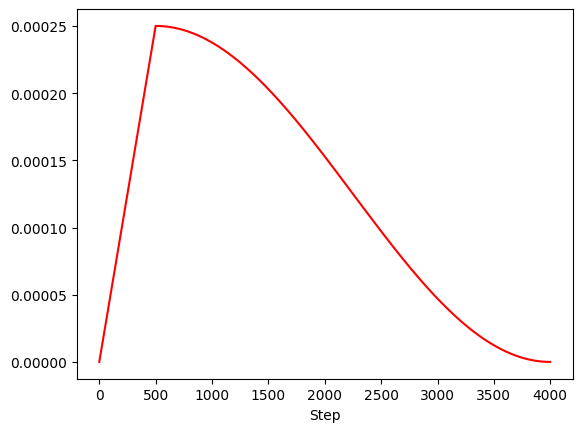

In [55]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [96]:
# 모델 생성
config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 512,
    "layernorm_epsilon": 0.001,
    "n_layer": 2,
    "n_seq": 256,
    "n_vocab": len(vocab), # 이 값을 0으로 했다가 계속 에러남
    "i_pad": 0
})

pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_tokens          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segments            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert (BERT)         │ [(None, 128),     │  1,586,560 │ enc_tokens[0][0], │
│                     │ (None, None,      │            │ segments[0][0]    │
│                     │ 8007)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_nsp          │ (None, 2)         │     16,768 │ bert[0][0]        │
│ (PooledOutput)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_output          │ (None, None,      │          0 │ bert[0][1]        │
│ (Softmax)           │ 8007)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nsp_output          │ (None, 2)         │          0 │ pooled_nsp[0][0]  │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,603,328 (6.12 MB)

 Trainable params: 1,603,328 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 컴파일

In [97]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(
    optimizer=optimizer,
    loss={
        "nsp_output": tf.keras.losses.SparseCategoricalCrossentropy(),
        "mlm_output": tf.keras.losses.SparseCategoricalCrossentropy()
    },
    metrics={
        "nsp_output": "accuracy",
        "mlm_output": lm_acc  # 커스텀 metric
    }
)

train_steps: 143470


### 모델 학습

In [98]:
# save weights callback
model_dir = "/content/drive/MyDrive/Colab Notebooks/models"
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.weights.h5", monitor="mlm_output_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(
    x={"enc_tokens": pre_train_inputs[0], "segments": pre_train_inputs[1]},
    y={"nsp_output": pre_train_labels[0], "mlm_output": pre_train_labels[1]},
    batch_size=batch_size,             # 64
    epochs=epochs,                     # 10
    callbacks=[save_weights],         # 모델 체크포인트 저장
)
# 모델 인자: inputs, labels, epochs, batch size, callback

Epoch 1/10
14347/14347 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4847 - mlm_output_lm_acc: 0.0194 - mlm_output_loss: 2.8753 - nsp_output_accuracy: 0.6287 - nsp_output_loss: 0.6095
Epoch 1: mlm_output_lm_acc improved from -inf to 0.02117, saving model to /content/drive/MyDrive/Colab Notebooks/models/bert_pre_train.weights.h5
14347/14347 ━━━━━━━━━━━━━━━━━━━━ 169s 10ms/step - loss: 3.4846 - mlm_output_lm_acc: 0.0194 - mlm_output_loss: 2.8752 - nsp_output_accuracy: 0.6287 - nsp_output_loss: 0.6095
Epoch 2/10
14343/14347 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3160 - mlm_output_lm_acc: 0.0314 - mlm_output_loss: 0.8069 - nsp_output_accuracy: 0.7623 - nsp_output_loss: 0.5091
Epoch 2: mlm_output_lm_acc improved from 0.02117 to 0.03877, saving model to /content/drive/MyDrive/Colab Notebooks/models/bert_pre_train.weights.h5
14347/14347 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - loss: 1.3160 - mlm_output_lm_acc: 0.0314 - mlm_output_loss: 0.8069 - nsp_output_accuracy: 0.7623 - nsp_output_loss: 0.50

### 학습 과정 시각화

In [149]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history

    # 손실 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist["loss"], label="total loss")
    plt.plot(hist["nsp_output_loss"], label="nsp loss")
    plt.plot(hist["mlm_output_loss"], label="mlm loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(hist["nsp_output_accuracy"], label="nsp accuracy")
    plt.plot(hist["mlm_output_lm_acc"], label="mlm accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


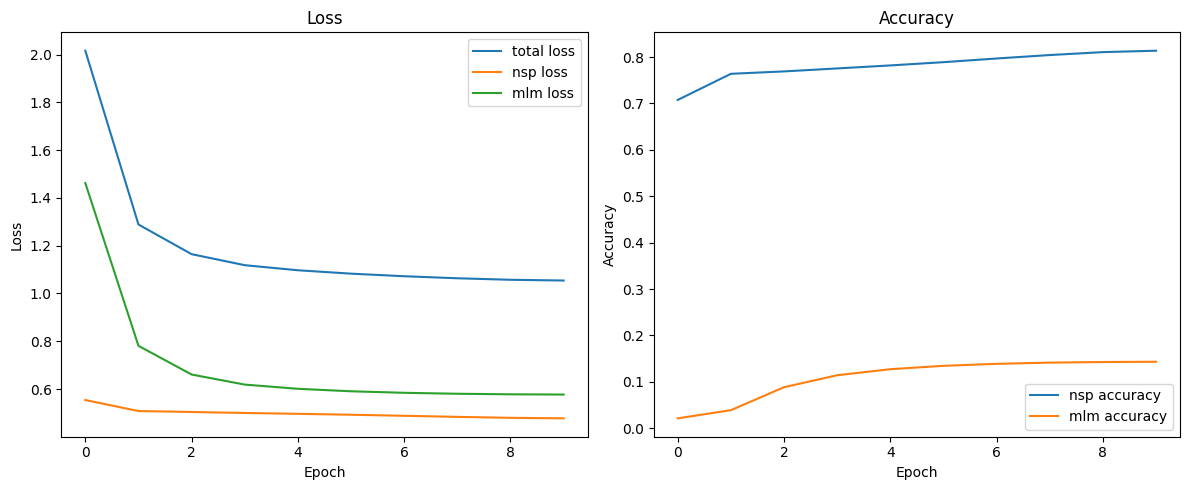

In [150]:
plot_history(history)


nsp와 mlm 모두 전체적으로 loss가 줄고 accuracy가 커지는 경향을 보임.(학습이 제대로 이루어짐)

## 모델 테스트

### 마스크 인퍼런스 확인

In [120]:
def predict_mlm(masked_sentence: str, vocab, model, topk: int = 5):
    pieces = vocab.encode(masked_sentence, out_type=str)
    print("🧩 토큰화 결과:", pieces)
    mask_token_id = vocab.piece_to_id("[MASK]")

    # 직접 토큰 변환
    token_ids = [vocab.piece_to_id(p) if p != "[MASK]" else mask_token_id for p in pieces]
    token_ids = np.array([token_ids], dtype=np.int32)
    segments = np.zeros_like(token_ids)

    # 예측 결과 받아오기 (딕셔너리)
    outputs = model.predict({"enc_tokens": token_ids, "segments": segments})
    mlm_logits = outputs["mlm_output"][0]

    mask_indices = np.where(token_ids[0] == mask_token_id)[0]

    if len(mask_indices) == 0:
        print("⚠️ [MASK] 토큰이 실제 입력에 없음.")
        print("Encoded tokens:", pieces)
        return

    for idx in mask_indices:
        if idx >= mlm_logits.shape[0]:
            print(f"⚠️ idx {idx} out of bounds for logits shape {mlm_logits.shape}")
            continue
        pred_logits = mlm_logits[idx]
        topk_ids = np.argsort(pred_logits)[-topk:][::-1]
        topk_tokens = [vocab.id_to_piece(int(i)) for i in topk_ids]
        topk_probs = tf.nn.softmax(pred_logits[topk_ids]).numpy()

        print(f"\n📍 위치 {idx}의 [MASK] 예측:")
        for t, p in zip(topk_tokens, topk_probs):
            print(f"  {t:<10} | {p:.4f}")


In [125]:
masked = "결과가 좋지 [MASK] 너무 슬퍼"
predict_mlm(masked_sentence=masked, vocab=vocab, model=pre_train_model)

🧩 토큰화 결과: ['▁결과', '가', '▁좋', '지', '▁', '[MASK]', '▁너무', '▁슬', '퍼']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

📍 위치 5의 [MASK] 예측:
  ▁때문에       | 0.2198
  ▁않고        | 0.2051
  ▁하지만       | 0.1951
  ▁않아        | 0.1907
  ▁못하고       | 0.1893


In [126]:
masked = "나는 지금 밥을 먹고 [MASK]"
predict_mlm(masked_sentence=masked, vocab=vocab, model=pre_train_model)

🧩 토큰화 결과: ['▁나', '는', '▁지금', '▁', '밥', '을', '▁먹', '고', '▁', '[MASK]']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

📍 위치 9의 [MASK] 예측:
  ▁있다        | 0.2473
  ▁          | 0.2068
  ▁먹         | 0.1855
  ▁한다        | 0.1809
  ▁있으며       | 0.1795


In [134]:
masked = "우리 가족을 소개합니다. 저는 아버지 [MASK]와 함께 살고 있어요."
predict_mlm(masked_sentence=masked, vocab=vocab, model=pre_train_model)

🧩 토큰화 결과: ['▁우리', '▁가족', '을', '▁소개', '합', '니다', '.', '▁저', '는', '▁아버지', '▁', '[MASK]', '와', '▁함께', '▁살', '고', '▁있어', '요', '.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

📍 위치 11의 [MASK] 예측:
  ▁같은        | 0.2066
  ▁친구        | 0.2010
  ▁사이에서      | 0.1981
  ▁어머니       | 0.1974
  ▁또는        | 0.1968


In [138]:
masked = "우리는 초등학교, 중학교, [MASK]를 같이 나왔어."
predict_mlm(masked_sentence=masked, vocab=vocab, model=pre_train_model)

🧩 토큰화 결과: ['▁우', '리는', '▁초등학교', ',', '▁중학교', ',', '▁', '[MASK]', '를', '▁같이', '▁나', '왔', '어', '.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

📍 위치 7의 [MASK] 예측:
  ▁같은        | 0.2194
  ▁중학교       | 0.1970
  ▁초등학교      | 0.1955
  ▁고등학교      | 0.1950
  ▁외에도       | 0.1931


- 대부분의 문장에서 좋지 못한 결과를 보여줬으나, 위 예시의 경우 그나마 상식에 맞는 예측을 수행하였다.
- 모델이 세부적인 문장의 내용을 이해하진 못하지만, 문장의 말미에 문장을 마무리하는 단어가 나오거나, 내용상 이어지는 부분의 단어를 맞히거나, 주변 단어와 유사한 단어를 예측하는 등의 경향을 보였다.
- 예시 문장들도 전부 가장 높은 확신도를 보이는 단어는 여러 문장에서 해당 위치에 많이 나오는 단어들이 차지했지만, 5개의 후보군 내에 화자가 생각한 올바른 단어가 포함되는 것을 확인하였다.

### NSP 인퍼런스 확인

In [140]:
def predict_nsp(sentence_a: str, sentence_b: str, vocab, model):
    # 두 문장을 하나로 합치고 segment 구분
    pieces_a = vocab.encode(sentence_a, out_type=int)
    pieces_b = vocab.encode(sentence_b, out_type=int)

    # 입력 구성: [CLS] A [SEP] B [SEP]
    cls_id = vocab.piece_to_id("[CLS]")
    sep_id = vocab.piece_to_id("[SEP]")

    input_ids = [cls_id] + pieces_a + [sep_id] + pieces_b + [sep_id]
    segment_ids = [0] * (len(pieces_a) + 2) + [1] * (len(pieces_b) + 1)

    # 배치 구성
    input_ids = np.array([input_ids], dtype=np.int32)
    segment_ids = np.array([segment_ids], dtype=np.int32)

    # 예측
    outputs = model.predict({"enc_tokens": input_ids, "segments": segment_ids})
    nsp_logits = outputs["nsp_output"][0]  # (2,)
    probs = tf.nn.softmax(nsp_logits).numpy()

    print(f"\n🧠 NSP 예측 결과:")
    print(f"  이어지는 문장일 확률 (is_next):     {probs[0]:.4f}")
    print(f"  무관한 문장일 확률 (not_next):     {probs[1]:.4f}")


#### 관련있는 문장 예시

In [141]:
predict_nsp(
    sentence_a="나는 오늘 도서관에 갔다.",
    sentence_b="책을 빌려서 공부했다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.3866
  무관한 문장일 확률 (not_next):     0.6134


In [142]:
predict_nsp(
    sentence_a="나는 오늘 카페에 갔다.",
    sentence_b="친구와 커피를 마시며 이야기를 나눴다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.3867
  무관한 문장일 확률 (not_next):     0.6133


In [143]:
predict_nsp(
    sentence_a="비가 많이 왔다.",
    sentence_b="그래서 우산을 챙겨 나갔다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.6120
  무관한 문장일 확률 (not_next):     0.3880


In [144]:
predict_nsp(
    sentence_a="고양이가 갑자기 달려들었다.",
    sentence_b="깜짝 놀라서 소리를 질렀다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.4237
  무관한 문장일 확률 (not_next):     0.5763


In [145]:
predict_nsp(
    sentence_a="그는 시험을 잘 보지 못했다.",
    sentence_b="그래서 기분이 매우 우울했다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.5571
  무관한 문장일 확률 (not_next):     0.4429


#### 무관한 문장 예시

In [146]:
predict_nsp(
    sentence_a="비가 많이 왔다.",
    sentence_b="어제 점심은 제육볶음이었다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.3919
  무관한 문장일 확률 (not_next):     0.6081


In [147]:
predict_nsp(
    sentence_a="그는 시험을 잘 보지 못했다.",
    sentence_b="고대 그리스에서는 철학이 중요시되었다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.4855
  무관한 문장일 확률 (not_next):     0.5145


In [148]:
predict_nsp(
    sentence_a="새로 산 핸드폰이 고장났다.",
    sentence_b="북한과 미국은 회담을 재개할 예정이다.",
    vocab=vocab,
    model=pre_train_model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🧠 NSP 예측 결과:
  이어지는 문장일 확률 (is_next):     0.3865
  무관한 문장일 확률 (not_next):     0.6135


- 관련있는 문장들에서 관련성을 파악하지 못하는 경우는 많았으나, 관련없는 문장에서는 대부분 정답을 맞혔다.
- 문장의 전체 내용을 이해하고 관련성을 파악하기보단 두 문장에 관련성이 있는 단어가 사용되었는지 판단하여 NSP 예측 결과를 내는 듯 보였다.

## 회고
- BERT 모델 구조를 학습 노드에서 공부할 때는 완벽히 이해했다고 판단하였지만, 코드 구조를 보니 그건 내 착각이었다. 이해하기가 너무 어려웠다.
- 코드를 구성하는 도중 모델 config에 잘못된 값을 입력하여 오류가 발생하였는데, 오류 코드에는 해당 값에 대한 내용이 담겨있지 않은 runtime 에러가 발생하여 이 값을 찾는 데 시간이 너무 오래 걸렸다.
- 모델 학습을 Colab 유료 버전에서 A100 GPU를 이용하여 돌렸다. 10 epoch을 돌리는 데 20분밖에 걸리지 않았다. 역시 돈이 최고라는 것을 느꼈다.
- 이번 실험에서는 주말 동안 학습 노드에 접근이 되지 않아 월요일에 모든 프로젝트를 진행하였다. 이전 프로젝트처럼 분기 실험을 하지 않아 오랜 시간이 걸리진 않았지만, 이후 비슷한 프로젝트를 하게 되면 모델 크기를 더 키워 더 그럴듯한 예측을 수행하는 모델을 만들고 싶다고 생각하였다.
- 이번 실험에서 분기 실험을 한다면 하이퍼 파라미터 중 어떤 값을 줄였을 때 학습 가능한 파라미터 개수 대비 가장 좋은 모델이 나올지 확인해볼 수 있었으면 좋았을 것 같다.